#### Raquel Peña.
#### Student number: 23083963

In [1]:
import numpy as np
import scipy as sp
from scipy import io
import cv2 as cv 
import matplotlib.pyplot as plt
import pylab
import os # for reading all files in a folder
pylab.rcParams['figure.figsize'] = (12.0, 10.0)

# Condensation 7c

You'll have to call the code below four times (once each with 'll','lr', 'ul', 'ur': lower left, lower right, upper left, ipper right). For each time you'll get an estimated track (2D locations over time) of one of the corners of the pattern moved. Note that we're saving off the single MAP estimate at each frame, but the particles in the Particle Filter are attempting to keep track of the whole posterior distribution. 

Most TO DO parts below should be copy-paste from Practical9a and Practical9b.

computeLikelihood has been modified from its previous versions to cope with these particular gray-scale images.


Qustions you could ask yourself (not a TO DO): 
- Can you find a pattern between the movement of the particles and the movement of the camera relative to the scene?
- When is the MAP estimate especially good/bad?
- What is the relationship to the amount of noise? (--> experiment with different levels!)
- Why do different numbers of particles lead to very differenet results (for example 50 vs. 2000)? 

In [2]:
#Likelihood function is simple patch similarity

def computeLikelihood(image, template):
    #opencv's available methods - experiment with these
    #careful what range the output is!
    methods = [cv.TM_CCOEFF, cv.TM_CCOEFF_NORMED, cv.TM_CCORR,
            cv.TM_CCORR_NORMED, cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]
    
    likelihood = cv.matchTemplate(image[:,:,2], template, methods[0])
    # (You can also try converting the image to greyscale instead of using the third channel as above with 
    #gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    #likelihood = cv.matchTemplate(gray_image, template, methods[0])

    
    #we can pad to make this the size of the input image (for easier indexing)   
    pad_first = int(template.shape[0])
    pad_second = int(template.shape[1])
    pad_amounts = ((0, pad_first-1), (0, pad_second-1))
    likelihood = np.pad(likelihood, pad_amounts, 'constant')
    likelihood[likelihood<0] = 0 # to avoid negative weights 
    
    # apply a 10x10 averaging filter for stability. You can experiment with different sizes. 
    kernel = np.ones((10,10),np.float32)/100
    smoothed = cv.filter2D(likelihood,-1,kernel) 
    return smoothed 

In [7]:
std_dev = 10  # Std noise 

def HW2_Practical7c(corner):
    template = sp.io.loadmat(corner+'.mat')['pixelsTemplate']
    #let's show the template
    print('We are matching this template with shape: ', template.shape)
    plt.imshow(template)
    plt.show()

    # Load all images in folder
    images = []
    iFrame = 0
    folder = 'Pattern01/'
    lst = os.listdir(folder)
    lst.sort()

    for frameNum in lst:
        images.append(cv.imread(folder+frameNum))
        iFrame += 1
    # plot first image 
    #plt.imshow(images[0])
    #plt.show()

    imgHeight, imgWidth, colors = images[0].shape
    numParticles = 2000;
    weight_of_samples = np.ones((numParticles,1))

    # TO DO: normalize the weights (may be trivial this time) [done]
    #weight_of_samples = weight_of_samples #replace this 
    weight_of_samples = weight_of_samples / np.sum(weight_of_samples)

    # Initialize which samples from "last time" we want to propagate: all of
    # them!:
    samples_to_propagate = range(0, numParticles)


    # ============================
    # NOT A TO DO: You don't need to change the code below, but eventually you may
    # want to vary the number of Dims (compare for example to lab 9b) 
    numDims_w = 2;
    # Here we randomly initialize some particles throughout the space of w:
    particles_old = np.random.rand(numParticles, numDims_w)
    particles_old[:,0] = particles_old[:,0] * imgHeight
    particles_old[:,1] = particles_old[:,1] * imgWidth
    # ============================

    #Initialize a temporary array r to store the per-frame MAP estimate of w. This is what we'll return in the end.
    r = np.zeros((iFrame, numDims_w));

    for iTime in range(iFrame):
        print('Processing Frame', iTime)
        # TO DO: compute the cumulative sume of the weights. [done]
        #cum_hist_of_weights = np.linspace(0, 1, numParticles) # replace this
        cum_hist_of_weights = np.cumsum(weight_of_samples)
        #print(weight_of_samples)


        # ==============================================================
        # Resample the old distribution at time t-1, and select samples, favoring
        # those that had a higher posterior probability.
        # ==============================================================
        samples_to_propagate = np.zeros(numParticles, dtype=np.int32)

        # Pick random thresholds in the cumulative probability's range [0,1]:
        some_threshes = np.random.rand(numParticles)


        # For each random threshold, find which sample in the ordered set is
        # the first one to push the cumulative probability above that
        # threshold, e.g. if the cumulative histogram goes from 0.23 to 0.26
        # between the 17th and 18th samples in the old distribution, and the
        # threshold is 0.234, then we'll want to propagate the 18th sample's w
        # (i.e. particle #18).

        for sampNum in range(numParticles): 
            thresh = some_threshes[sampNum]
            for index in range (numParticles):
                if cum_hist_of_weights[index] > thresh:
                    break
            samples_to_propagate[sampNum] = index

        # Note: it's ok if some of the old particles get picked repeatedly, while
        # others don't get picked at all.


        # =================================================
        # Visualize if you want
        # =================================================
        #plt.title('Cumulative histogram of probabilities for sorted list of particles')
        #plt.plot(np.zeros(numParticles), some_threshes,'b.')
        #plt.plot(range(0, numParticles), cum_hist_of_weights, 'rx-')
        #which_sample_ids = np.unique(samples_to_propagate)
        #how_many_of_each = np.bincount(np.ravel(samples_to_propagate))
        #for k in range(len(which_sample_ids)):
        #    plt.plot(which_sample_ids[k], 0, 'bo-', markersize = 3 * how_many_of_each[k], markerfacecolor='white')
        #plt.xlabel('Indeces of all available samples, with larger blue circles for frequently re-sampled particles\n(Iteration %01d)' % iTime)
        #plt.ylabel('Cumulative probability');
        #plt.show()
        # =================================================
        # =================================================

        # Predict where the particles we sampled from the old distribution of 
        # state-space will go in the next time-step. This means we have to apply 
        # the motion model to each old sample.
        particles_new = np.zeros_like(particles_old)
        for particleNum in range(numParticles):
            # TO DO: Incorporate some noise, e.g. Gaussian noise with std 20,
            # into the current location (particles_old), to give a Brownian
            # motion model.
            #particles_new[particleNum, :] =  particles_old[particleNum, :] # replace this
            noise = np.random.normal(0, std_dev, numDims_w)  # Noise for each w dimension
            particles_new[particleNum, :] = particles_old[samples_to_propagate[particleNum]] + noise  
 
            
        # TO DO: Not initially, but change the motion model above to have
        # different degrees of freedom, and optionally completely different
        # motion models. See Extra Credit for more instructions.

        #calculate likelihood function
        likelihood = computeLikelihood(images[iTime], template)

        #plot results
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(images[iTime])
        axarr[0].set_title('Particles')
        # now draw the particles onto the image
        axarr[0].plot(particles_new[:,1]+template.shape[1]/2, particles_new[:,0]+template.shape[0]/2, 'rx')

        #plot the likelihood
        axarr[1].imshow(likelihood)
        axarr[1].set_title('Likelihood')



        # From here we incorporate the data for the new state (time t):
        # The new particles accompanying predicted locations in state-space
        # for time t, are missing their weights: how well does each particle
        # explain the observations x_t?
        for particleNum in range(numParticles):

            # Convert the particle from state-space w to measurement-space x:
            # Note: that step is trivial here since both are in 2D space of image
            # coordinates

            # Within the loop, we evaluate the likelihood of each particle:
            particle = particles_new[particleNum, :]
            # Check that the predicted location is a place we can really evaluate
            # the likelihood.
            inFrame = particle[0] >= 0.0 and  particle[0] <= imgHeight and particle[1] >= 0.0 and particle[1] <= imgWidth
            if inFrame:
                minX = particle[1]
                minY = particle[0]

                weight_of_samples[particleNum] = likelihood[int(minY), int(minX)]

            else:
                weight_of_samples[particleNum] = 0.0

        # TO DO: normalize the weights [done]
        #weight_of_samples = weight_of_samples # replace this
        weight_of_samples = weight_of_samples / np.sum(weight_of_samples)

        # find the location of the particle with highest weight
        indices = np.argsort(weight_of_samples,0)
        bestScoringParticles = particles_new[np.squeeze(indices[-15:]), :]
        plt.plot(bestScoringParticles[-1:,1], bestScoringParticles[-1:,0], 'rx')
        # Return the MAP of middle position. Add template.shape/2 because matchTemplate finds the position of the upper left corner 
        # of the template. We want to plot the centre of the template. 
        r[iTime,:] = bestScoringParticles[-1,1]+template.shape[1]/2,bestScoringParticles[-1,0]+template.shape[0]/2
        print(r[iTime,:])   
        plt.show()

        #print the original image and the position of the tracked corner.
        plt.imshow(images[iTime])
        plt.plot(r[iTime,0],r[iTime,1],'rx')
        plt.show()
        # Now we're done updating the state for time t. 
        # For Condensation, just clean up and prepare for the next round of 
        # predictions and measurements:
        particles_old = particles_new

    return r

In [ ]:
ur = HW2_Practical7c( 'ur' )

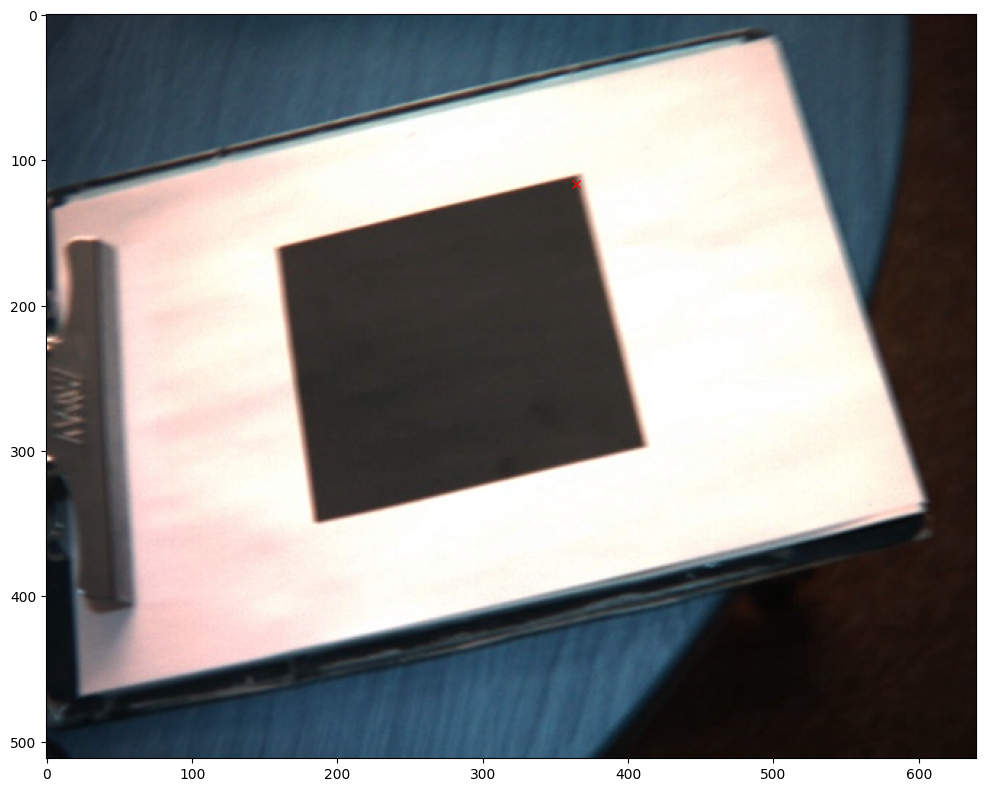

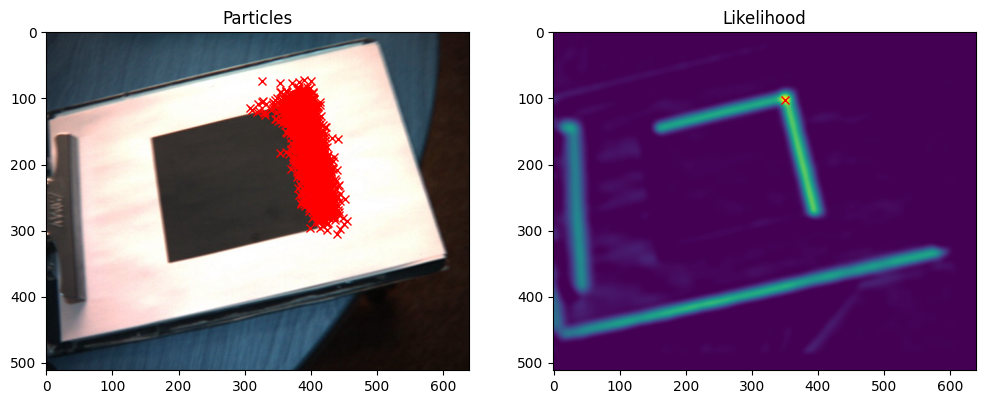

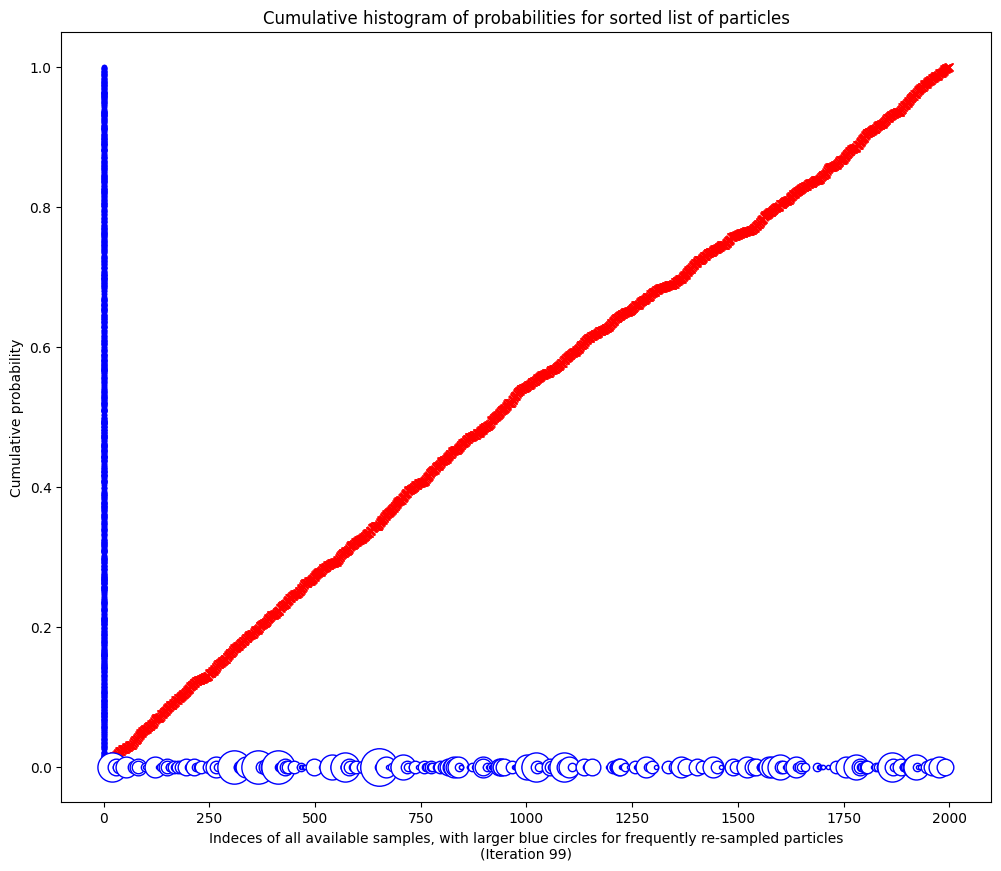

Note: Because of memorie I only showed the last iteration.

In this exercise, it is observed that precision improves significantly when the standard deviation is reduced to 10 and the particle count is maintained at 2,000. Initially, the likelihood function highlighted brighter areas in incorrect locations, such as the top of the clip, indicating that the algorithm was still in the process of learning the distribution of the object of interest, which in this case is the upper right corner of the black square. 

For the final iteration, the red cross, representing the best estimate, is located at the upper right edge, aligning with our target, which confirms that the condensation algorithm is performing effectively.

In [ ]:
#URss = HW2_Practical7c( 'ul' )

In [ ]:
#lr = HW2_Practical7c( 'lr' )

In [ ]:
#ll = HW2_Practical7c( 'll' )